In [1]:
import os
import cv2
import numpy as np

In [19]:
def nlm_denoising_preprocessing(image):
    image = (image * 255).astype(np.uint8)
    
    image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

In [4]:
data_dir = "Major2-bloodgroup-fingerprint"

classes = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator with custom preprocessing
nlm_datagen = ImageDataGenerator(
    preprocessing_function=nlm_denoising_preprocessing,  # Apply custom preprocessing
    validation_split=0.2  # 80-20 train-validation split
)

# Create training generator
nlm_train_data = nlm_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',  
    subset='training',
    classes=classes
)

# Create validation generator
nlm_val_data = nlm_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',
    classes=classes
)

Found 6336 images belonging to 8 classes.
Found 1584 images belonging to 8 classes.


In [8]:
print("Class labels detected:", nlm_train_data.class_indices)


Class labels detected: {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    nlm_train_data,
    epochs=10,
    validation_data=nlm_val_data,
    callbacks=[early_stopping]
)


Epoch 1/10


2025-03-09 03:47:05.103174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


198/198 ━━━━━━━━━━━━━━━━━━━━ 2526s 13s/step - accuracy: 0.3806 - loss: 9.0992 - val_accuracy: 0.4741 - val_loss: 1.8707
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 10623s 54s/step - accuracy: 0.7803 - loss: 0.6522 - val_accuracy: 0.5158 - val_loss: 1.8037
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.9390 - loss: 0.1988 - val_accuracy: 0.5177 - val_loss: 1.9245
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9635 - loss: 0.1123 - val_accuracy: 0.5758 - val_loss: 1.7677
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.9856 - loss: 0.0530 - val_accuracy: 0.5979 - val_loss: 1.7379
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9992 - loss: 0.0129 - val_accuracy: 0.6237 - val_loss: 1.7127
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.9794 - loss: 0.1006 - val_accuracy: 0.5777 - val_loss: 1.7194
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step - accuracy: 0.9987 - loss: 0.0168 - val_accuracy: 

In [27]:
loss, accuracy = model.evaluate(nlm_val_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 938ms/step - accuracy: 0.6349 - loss: 1.6634
Validation Loss: 1.7127
Validation Accuracy: 0.6237


In [28]:

def gaussian_blur_preprocessing(image):

    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)
    return image


In [29]:
classes = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

datagen_blur = ImageDataGenerator(preprocessing_function=gaussian_blur_preprocessing, validation_split=0.2)

train_data_blur = datagen_blur.flow_from_directory(
    data_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training',
    color_mode='grayscale',  
    classes=classes  
)

val_data_blur = datagen_blur.flow_from_directory(
    data_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation',
    color_mode='grayscale',  
    classes=classes  
)

Found 6336 images belonging to 8 classes.
Found 1584 images belonging to 8 classes.


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

blur_history = model.fit(
    train_data_blur,
    epochs=10,
    validation_data=val_data_blur,
    callbacks=[early_stopping]
)

Epoch 1/10


/Users/insiyar/Documents/Development/bloodgroup-fingerprint/fingerprint_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy: 0.5996 - loss: 1.0878 - val_accuracy: 0.5455 - val_loss: 1.6010
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.8059 - loss: 0.5174 - val_accuracy: 0.5808 - val_loss: 1.4552
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - accuracy: 0.8946 - loss: 0.2931 - val_accuracy: 0.6212 - val_loss: 1.5579
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 238ms/step - accuracy: 0.9458 - loss: 0.1633 - val_accuracy: 0.5827 - val_loss: 2.1425
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - accuracy: 0.9594 - loss: 0.1229 - val_accuracy: 0.6389 - val_loss: 1.7719
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [31]:
loss, accuracy = model.evaluate(val_data_blur)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5903 - loss: 1.4170
Validation Loss: 1.4552
Validation Accuracy: 0.5808


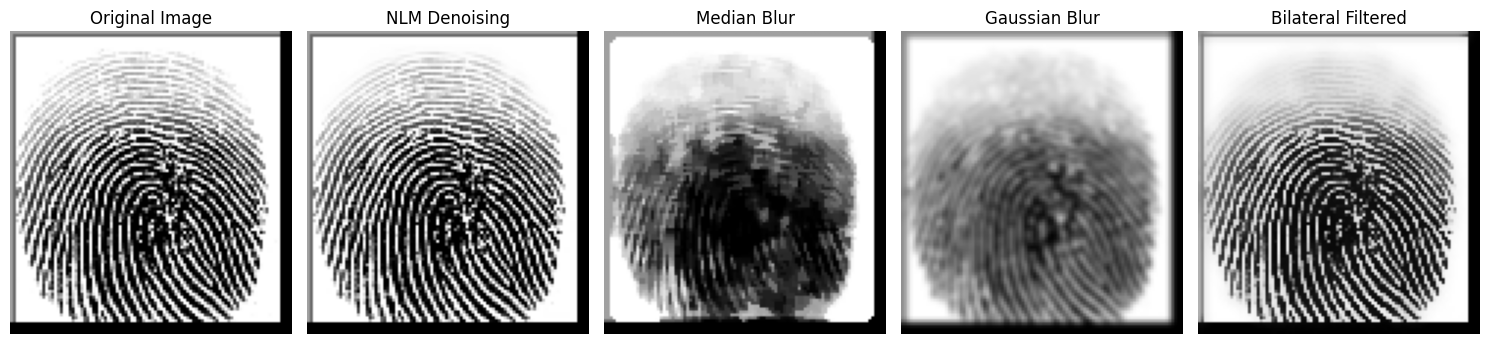

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Lsample fingerprint image
img = cv2.imread('Major2-bloodgroup-fingerprint/A-/cluster_1_5482.BMP', cv2.IMREAD_GRAYSCALE)

# Apply different denoising and blurring techniques
nlm_denoised = cv2.fastNlMeansDenoising(img, h=10)  # Non-Local Means Denoising
median_blur = cv2.medianBlur(img, ksize=5)           # Median Blur
gaussian_blur = cv2.GaussianBlur(img, (5, 5), 0)     # Gaussian Blur
bilateral_filtered = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75) #bilateral filtering

# Display the images
plt.figure(figsize=(15, 8))

plt.subplot(1, 5, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(nlm_denoised, cmap='gray')
plt.title('NLM Denoising')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(median_blur, cmap='gray')
plt.title('Median Blur')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(gaussian_blur, cmap='gray')
plt.title('Gaussian Blur')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(bilateral_filtered, cmap='gray')
plt.title('Bilateral Filtered')
plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
data_dir = "Major2-bloodgroup-fingerprint"

classes = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

In [ ]:
def bilateral_filter_preprocessing(image):

    image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

bilateral_datagen = ImageDataGenerator(
    preprocessing_function=bilateral_filter_preprocessing,
    validation_split=0.2  
)


train_data_bilateral = bilateral_datagen.flow_from_directory(
    data_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training',
    color_mode='grayscale',  
    classes=classes  
)

val_data_bilateral = bilateral_datagen.flow_from_directory(
    data_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation',
    color_mode='grayscale',  
    classes=classes  
)

Found 6336 images belonging to 8 classes.
Found 1584 images belonging to 8 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/insiyar/Documents/Development/bloodgroup-fingerprint/fingerprint_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-09 09:35:37.526946: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-09 09:35:37.527137: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-09 09:35:37.527148: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-09 09:35:37.527332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-09 09:35:37.527368: I tensorflow/core/common_run

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

bilateral_history = model.fit(
    train_data_bilateral,
    epochs=10,
    validation_data=val_data_bilateral,
    callbacks=[early_stopping]
)

Epoch 1/10


2025-03-09 09:35:59.243358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2897 - loss: 25.6210

/Users/insiyar/Documents/Development/bloodgroup-fingerprint/fingerprint_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.2903 - loss: 25.5374 - val_accuracy: 0.4047 - val_loss: 1.8103
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - accuracy: 0.7047 - loss: 0.7995 - val_accuracy: 0.5189 - val_loss: 1.9240
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - accuracy: 0.8480 - loss: 0.4144 - val_accuracy: 0.5505 - val_loss: 1.5784
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 239ms/step - accuracy: 0.9221 - loss: 0.2401 - val_accuracy: 0.5619 - val_loss: 1.6550
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 51s 259ms/step - accuracy: 0.9561 - loss: 0.1400 - val_accuracy: 0.5682 - val_loss: 2.1017
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.9794 - loss: 0.0870 - val_accuracy: 0.6004 - val_loss: 1.6656
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [14]:
loss, accuracy = model.evaluate(val_data_bilateral)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5716 - loss: 1.5352
Validation Loss: 1.5784
Validation Accuracy: 0.5505
